<center>
    <h1 id='statistic-analysis' style='color:#7159c1'>📊 Statistic Analysis 📊</h1>
    <i>Exploring and studying the Animes and Users Details Datasets</i>
</center>

> **Topics**

```
- 🔎 Exploratory Analysis;
- 📊 Plots;
- 🧪 Hypothesis Testing.
```

In [84]:
# ---- Imports ----
import matplotlib.pyplot as plt  # pip install matplotlib
import numpy as np               # pip install numpy
import pandas as pd              # pip install pandas
import seaborn as sns            # pip install seaborn
import scipy.stats as stats      # pip install scipy

# ---- Constants ----
DATASETS_PATH = ('./datasets')
SEED = (20231105)

# ---- Settings ----
np.random.seed(SEED)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# ---- Functions ----
def transform_genres(dataset):
    """
    \ Description:
        - transforms the genres column into multiple new columns;
        - 0 values tell that the anime does not contain the genre;
        - 1 values tell that the anime contain the genre.
    
    \ Parameters:
        - dataset: Pandas DataFrame.
        
    \ Example:
        genres = {genres: 'action, mistery, sci-fi'}
        
        result = {
            genres: 'action, mistery, sci-fi',
            genre_action: 1,
            genre_mistery: 1,
            genre_adventure: 0,
            genre_sci_fi: 1,
        }
    """
    dataset['genres'] = dataset['genres'].str.split(', ')
    
    unique_genres = set()
    for genres_list in dataset['genres']: unique_genres.update(genres_list)
        
    for genre in unique_genres: dataset[f'genre_{genre.replace(" ", "_").replace("-", "_")}'.lower()] = 0
    
    for index, row in dataset.iterrows():
        for genre in row['genres']: dataset.at[index, f'genre_{genre.replace(" ", "_").replace("-", "_")}'.lower()] = 1
        
def create_frequency_table(dataset, variable):
    """
    \ Description:
        - calculates the cross table of a variable from a dataset;
        - drops margin column;
        - adds 'percentage' column into the cross table;
        - sorts by the variable's values;
        - returns the result
    
    \ Parameters:
        - dataset: Pandas DataFrame;
        - variable: string.
    """
    frequencies = pd.crosstab(
        index=dataset[variable]
        , columns='count'
        , colnames=['']
        , margins=True
    )
    frequencies = frequencies.iloc[:, :-1] # removing 'All' margin column
    total_count = frequencies.loc['All', 'count'] # getting 'count' value at 'all' row
    frequencies['percentage'] = round(frequencies['count'] / total_count, 4) # four significant digits
    frequencies.sort_values(by='count', ascending=True)
    return frequencies

def describe_numerical_variables(dataset):
    """
    \ Description:
        - calculates the common describe;
        - calculates the Mean Absolute Error (MAD) ;
        - calculates the Median, Variance, Skewness, Kurtosis and Standard Error of the Mean (SEM);
        - returns the concatenation of the three previous calculations.
    
    \ Parameters:
        - dataset: Pandas DataFrame.
    """
    # ---- Calculating the Common Describe ----
    common_describe = dataset.describe()
    
    # ---- Calculating Mean Absolute Deviation (MAD) ----
    mad_describe = lambda dataset: pd.DataFrame((dataset - dataset.mean()).abs().mean()).T.set_index(pd.Index(['mad']))
    mad_df = mad_describe(dataset)
    
    # ---- Calculating Other Statistics ----
    stats_df = dataset.reindex(dataset.columns, axis=1).agg(['median', 'var', 'skew', 'kurt', 'sem'])
    
    # ---- Concatenating the Results ----
    return pd.concat([common_describe, mad_df, stats_df]).reindex(['count', 'mean', 'sem', 'var', 'std', 'median', 'mad', 'min', '25%', '50%', '75%', 'max', 'skew', 'kurt'])

def identify_outliers(dataset, variable):
    """
    \ Description:
        - calculates the lower and upper bounds for outliers using the InterQuartile Range approach;
        - finds the elements that are lower and upper outliers;
        - returns a copy of the dataset containing only the outliers.
    
    \ Parameters:
        - dataset: Pandas DataFrame;
        - variable: string.
    """
    first_quartile, third_quartile = dataset[variable].quantile(0.25), dataset[variable].quantile(0.75)
    interquartile_range = third_quartile - first_quartile
    
    lower_bound = first_quartile - 1.5 * interquartile_range
    upper_bound = third_quartile + 1.5 * interquartile_range
    
    lower_outliers = dataset[variable].loc[dataset[variable] < lower_bound]
    upper_outliers = dataset[variable].loc[dataset[variable] > upper_bound]
    return pd.concat([lower_outliers, upper_outliers])

# \ Description:
#    - returns the Standard Scaler of dataset variables.
#
# \ Standard Scaler:
#    - Equation: y = (x - mean(x)) / interquartile_range;
#    - Result: Standard Normal Distribution (Z).
#
# \ Parameters:
#    - dataset: Pandas DataFrame.
#
standard_scaler = lambda dataset: (dataset - dataset.mean()) / (dataset.quantile(0.75) - dataset.quantile(0.25))

# \ Description:
#    - returns the Min-Max Scaler of dataset variables.
#
# \ Min-Max Scaler:
#    - Equation: y = (x - min(x)) / (max(x) - min(x));
#    - Result: all values are scaled into a range from 0 to 1.
#
# \ Parameters:
#    - dataset: Pandas DataFrame.
#
min_max_scaler = lambda dataset: (dataset - dataset.min()) / (dataset.max() - dataset.min())

# \ Description:
#    - returns the Robust Scaler of dataset variables.
#
# \ Robust Scaler:
#    - Equation: y = (x - median(x)) / interquartile_range >> the third quartile has been
# replaced by the second one due to the variables values;
#    - Result: all values are scaled ignoring outliers influence.
#
# \ Parameters:
#    - dataset: Pandas DataFrame.
#
robust_scaler = lambda dataset: (dataset - dataset.median()) / (dataset.quantile(0.50) - dataset.quantile(0.25))

<h1 id='0-exploratory-analysis' style='color:#7159c1; border-bottom:3px solid #7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-weight: bold; text-align:left; font-size:240%;padding:0'>🔎 | Exploratory Analysis</h1>


In this section, we are going to apply the Descriptive Analysis in order to understand how the data are spread, see their frequencies and distributions, as well as check out the correlation between the variables.

Also, we are going to create a new animes dataset transforming the genres variable for a better graphic exploration.

<br />

<p style='color:#7159c1; letter-spacing:2px; font-family:JetBrains Mono; font-size:150%'>0.1 | Anime Dataset</p>

> **Steps**

```
- Transforming Genres;
- Separating Categorical Variables from Numerical Variables and Genres Variables;
- Categorical Variables: Describe, Frequence Table and Conclusions;
- Numerical Variables: Describe, Histograms, Correlations, HeatMap Plot and Conclusions;
- Genre Variables: Describe, Frequence Table, Bar Plots, Correlations, HeatMap Plot and Conclusions.
```

---

---

**- Transforming Genres**

First of all, we are going to create a new dataset called `anime-exploratory-dataset-2023.csv` where the `genres variable` is considered as multiple variables. For instance, consider 'Cowboy Bebop', its genres are 'sci-fi', 'action' and 'award winning', so, the exploratory dataset will look like this:

<table style='border-style: solid'>
    <caption>Dataset Before Transformation</caption>
    <tr align='center' style='border-style: solid'>
        <th style='border-style: solid'>id</th>
        <th style='border-style: solid'>name</th>
        <th style='border-style: solid'>genres</th>
    </tr>
    <tr align='center' style='border-style: solid'>
        <td style='border-style: solid'>1</td>
        <td style='border-style: solid'>cowboy bebop</td>
        <td style='border-style: solid'>sci-fi, action, award winning</td>
    </tr>
</table>

<table style='border-style: solid'>
    <caption>Dataset After Transformation</caption>
    <tr align='center' style='border-style: solid'>
        <th style='border-style: solid'>id</th>
        <th style='border-style: solid'>name</th>
        <th style='border-style: solid'>genres</th>
        <th style='border-style: solid'>genre_sci_fi</th>
        <th style='border-style: solid'>genre_action</th>
        <th style='border-style: solid'>genre_mistery</th>
        <th style='border-style: solid'>genre_award_winning</th>
    </tr>
    <tr align='center' style='border-style: solid'>
        <td style='border-style: solid'>1</td>
        <td style='border-style: solid'>cowboy bebop</td>
        <td style='border-style: solid'>['sci-fi', 'action', 'award winning']</td>
        <td style='border-style: solid'>1</td>
        <td style='border-style: solid'>1</td>
        <td style='border-style: solid'>0</td>
        <td style='border-style: solid'>1</td>
    </tr>
</table>

<br />

> **Observation** - there will be a variable called `genre_`. It represents when the anime does not contain associated genres.

In [2]:
# ---- Reading Dataset ----
animes_df = pd.read_csv(f'{DATASETS_PATH}/anime-transformed-dataset-2023.csv')
print(f'- Initial Number of Variables: {animes_df.shape[1]}')
print(f'- Initial Number of Rows: {animes_df.shape[0]}')
print('---')

# ---- Transforming Genres ----
transform_genres(animes_df)
print(f'- Current Number of Variables: {animes_df.shape[1]}')
print(f'- Current Number of Observations: {animes_df.shape[0]}')
print('---')

# ---- Exporting Transformed Dataset ----
animes_df.to_csv(f'{DATASETS_PATH}/anime-exploratory-dataset-2023.csv', index=False)
del animes_df

# ---- Reading New Dataset ----
anime_exploratory_df = pd.read_csv(f'{DATASETS_PATH}/anime-exploratory-dataset-2023.csv')
anime_exploratory_df.head()

- Initial Number of Variables: 19
- Initial Number of Rows: 23748
---
- Current Number of Variables: 41
- Current Number of Observations: 23748
---


,id,title,score,genres,synopsis,type,episodes,status,producers,licensors,studios,source,duration,rating,rank,popularity,favorites,scored_by,members,genre_girls_love,genre_gourmet,genre_adventure,genre_horror,genre_slice_of_life,genre_avant_garde,genre_supernatural,genre_action,genre_fantasy,genre_sci_fi,genre_sports,genre_suspense,genre_romance,genre_hentai,genre_award_winning,genre_mystery,genre_drama,genre_ecchi,genre_boys_love,genre__,genre_erotica,genre_comedy
0,1,cowboy bebop,8.75,"['sci-fi', 'award winning', 'action']","crime is timeless. by the year 2071, humanity ...",tv,26,finished airing,bandai visual,"bandai entertainment, funimation",sunrise,original,24 min per ep,R - 17+ (violence & profanity),41,43,78525,914193,1771505,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,5,cowboy bebop tengoku no tobira,8.38,"['sci-fi', 'action']","another day, another bounty—such is the life o...",movie,1,finished airing,"sunrise, bandai visual",sony pictures entertainment,bones,original,1 hr 55 min,R - 17+ (violence & profanity),189,602,1448,206248,360978,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,6,trigun,8.22,"['adventure', 'sci-fi', 'action']","vash the stampede is the man with a $$60,000,0...",tv,26,finished airing,victor entertainment,"geneon entertainment usa, funimation",madhouse,manga,24 min per ep,PG-13 - Teens 13 or older,328,246,15035,356739,727252,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,7,witch hunter robin,7.25,"['supernatural', 'drama', 'mystery', 'action']",robin sena is a powerful craft user drafted in...,tv,26,finished airing,"bandai visual, victor entertainment, tv tokyo ...","bandai entertainment, funimation",sunrise,original,25 min per ep,PG-13 - Teens 13 or older,2764,1795,613,42829,111931,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,8,bouken ou beet,6.94,"['adventure', 'supernatural', 'fantasy']",it is the dark century and the people are suff...,tv,52,finished airing,"tv tokyo, dentsu",illumitoon entertainment,toei animation,manga,23 min per ep,PG - Children,4240,5126,14,6413,15001,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


---

**- Separating Categorical Variables from Numerical and New Genres Variables;**

Now, since the statistic is applied differently in categorical and numerical variables, we have to identify and separate them. Also, even the new genres variables being numerical, we are going to separate them from the numerical ones in order to analyse them separately.

So, let's go!!

In [3]:
# ---- Separating Categorical from Numerical Variables ----
categorical_variables = [
    variable for variable in anime_exploratory_df.columns
    if anime_exploratory_df[variable].dtype in ['O', 'object']
]

numerical_variables = [
    variable for variable in anime_exploratory_df.columns
    if anime_exploratory_df[variable].dtype in ['int64', 'float64', 'int32', 'float32']
        and not variable.startswith('genre_')
]

genre_variables = [
    variable for variable in anime_exploratory_df.columns
    if anime_exploratory_df[variable].dtype in ['int64', 'float64', 'int32', 'float32']
        and variable.startswith('genre_')
]

print(f'- Categorical Variables: Count: {len(categorical_variables)} - {categorical_variables}\n')
print(f'- Numerical Variables: Count: {len(numerical_variables)} - {numerical_variables}\n')
print(f'- Genre Variables:  Count: {len(genre_variables)} - {genre_variables}')

- Categorical Variables: Count: 11 - ['title', 'genres', 'synopsis', 'type', 'status', 'producers', 'licensors', 'studios', 'source', 'duration', 'rating']

- Numerical Variables: Count: 8 - ['id', 'score', 'episodes', 'rank', 'popularity', 'favorites', 'scored_by', 'members']

- Genre Variables:  Count: 22 - ['genre_girls_love', 'genre_gourmet', 'genre_adventure', 'genre_horror', 'genre_slice_of_life', 'genre_avant_garde', 'genre_supernatural', 'genre_action', 'genre_fantasy', 'genre_sci_fi', 'genre_sports', 'genre_suspense', 'genre_romance', 'genre_hentai', 'genre_award_winning', 'genre_mystery', 'genre_drama', 'genre_ecchi', 'genre_boys_love', 'genre__', 'genre_erotica', 'genre_comedy']


---

**- Categorical Variables: Describe, Frequence Table and Conclusions**

Steps:

> **Describe** - `get the major statistical overview of all categorical variables`;

> **Frequency Tables** - `get the frequency tables of type/status/rating variables`.

In [4]:
# ---- Describe ----
anime_exploratory_df[categorical_variables].describe()

,title,genres,synopsis,type,status,producers,licensors,studios,source,duration,rating
count,23748,23748,23748,23748,23748,23748,23748,23748,23748,23748,23748
unique,23681,992,19634,7,2,4351,265,1518,17,330,7
top,gintama,['-'],-,tv,finished airing,-,-,-,original,24 min per ep,PG-13 - Teens 13 or older
freq,4,4505,3856,6950,23405,12442,19020,9671,9018,1952,8313


Describe Conclusions:

> **Number of Observations** - there are `23,748 animes` observations in the dataset;

> **Most Common Rating** - 35% of the animes are destined for `13 years-old or older public`;

> **Most Common Status** - 98% of the animes are already `finished airing (finished releasing)`;

> **Most Common Type** - 29% of the animes has been released on `TV` in episodes format;

> **Most Common Duration** - 8% of the animes has a duration of `24 minutes per episode`.

In [5]:
# ---- Frequence Table: One-Way ----
#
# - type;
# - status;
# - rating.
#
type_frequencies = create_frequency_table(anime_exploratory_df, 'type')
status_frequencies = create_frequency_table(anime_exploratory_df, 'status')
rating_frequencies = create_frequency_table(anime_exploratory_df, 'rating')

In [6]:
# ---- Animes Type Frequencies ----
print('Animes Type Frequencies')
type_frequencies

Animes Type Frequencies


,count,percentage
type,,
-,4,0.0002
movie,4282,0.1803
music,2682,0.1129
ona,3320,0.1398
ova,3977,0.1675
special,2533,0.1067
tv,6950,0.2927
All,23748,1.0000


In [7]:
# ---- Animes Status Frequencies ----
print('Animes Status Frequencies')
status_frequencies

Animes Status Frequencies


,count,percentage
status,,
currently airing,343,0.0144
finished airing,23405,0.9856
All,23748,1.0000


In [8]:
# ---- Animes Rating Frequencies ----
print('Animes Rating Frequencies')
rating_frequencies

Animes Rating Frequencies


,count,percentage
rating,,
-,407,0.0171
G - All Ages,7517,0.3165
PG - Children,3541,0.1491
PG-13 - Teens 13 or older,8313,0.3501
R - 17+ (violence & profanity),1377,0.0580
R+ - Mild Nudity,1129,0.0475
Rx - Hentai,1464,0.0616
All,23748,1.0000


---

**- Numerical Variables: Describe, Histograms, Correlations, HeatMap Plot and Conclusions**

In [9]:
# ---- Describe ----
describe_numerical_variables(anime_exploratory_df[numerical_variables])

,id,score,episodes,rank,popularity,favorites,scored_by,members
count,2.374800e+04,23748.000000,23748.000000,2.374800e+04,2.374800e+04,2.374800e+04,2.374800e+04,2.374800e+04
mean,2.889156e+04,3.874851,13.796783,8.073826e+03,1.205125e+04,4.516434e+02,1.980560e+04,3.860108e+04
sem,1.161569e+02,0.023206,0.306778,4.193159e+01,4.581231e+01,2.892066e+01,6.236473e+02,1.040710e+03
var,3.204183e+08,12.788582,2234.995295,4.175512e+07,4.984155e+07,1.986294e+07,9.236450e+09,2.572092e+10
std,1.790023e+04,3.576113,47.275737,6.461820e+03,7.059854e+03,4.456785e+03,9.610645e+04,1.603774e+05
median,3.354050e+04,5.710000,2.000000,7.583500e+03,1.206300e+04,1.000000e+00,3.675000e+02,1.149500e+03
mad,1.585110e+04,3.314530,16.241688,5.662125e+03,6.105322e+03,7.969764e+02,3.157418e+04,5.963576e+04
min,1.000000e+00,-1.000000,-1.000000,-1.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00
25%,9.881750e+03,-1.000000,1.000000,1.648750e+03,5.949750e+03,0.000000e+00,-1.000000e+00,2.350000e+02
50%,3.354050e+04,5.710000,2.000000,7.583500e+03,1.206300e+04,1.000000e+00,3.675000e+02,1.149500e+03


Describe Conclusions:

> **Number of Observations** - there are `23,748 animes` observations in the dataset;

> **Average Anime Score** - the mean score is `3.87`;

> **Average Number of Episodes** - the animes has a mean of `13 episodes`;

> **Episodes Spreadness** - the animes has a high standard deviation of episodes (`47 episodes`). That is, if a new anime is going being released, we can tell that it is gonna have between 1 to 60 episodes;

> **Scored By Spreadness** - the number of users that scored each anime also contains a high standard deviation. So some animes has been scored by a bunch of users and other by only a few users. This can directly impact in the final anime score;

> **Kurtosis** - all variables have `a too high or a too small kurtosis value` (smaller than -1 and higher than +1), meaning that the variables distributions are not Normal Distributions;

> **Scale** - the variables have a huge difference between their ranges. For instance, the score goes from -1 to 9.10, while rank goes from -1 to 20,104. This is a problem to our histograms visualizations, so we have to treat it `scaling` all variables into the same range.

---

**- Scaling**

Since the variables have a huge difference between their ranges, we have to re-scale their values into a same range before ploting their distributions, in order to turn the visualization easier.

There are many Scalers Algorithms, being `Standard Scaler, Min-Max Scaler and Robust Scaler` the main ones, so let's see some explanations about each of them:

> **Standard Scaler** - `only applied when the variable has a Normal Distribution; transforms the distribution into a Standard Normal Distribution (Z); transforms the arithmetic mean to 0 and standard deviation to 1; it is very sensitive to ouliers.`

Equation:

```python
scaled_x = (x - mean(x)) / IQR
```

$$
scaled_x = \frac{x - mean(x)}{IQR}
$$

where:

- x: the value;
- IQR: InterQuartile Range.

<br /><br />

> **Min-Max Scaler** - `applied regardless the variable has or not a Normal Distribution; transforms the variable into a range from 0 to 1; it is very sensitive to outliers.`

Equation:

```python
scaled_x = (x - min(x)) / (max(x) - min(x))
```

$$
scaled_x = \frac{x - min(x)}{max(x) - min(x)}
$$

<br /><br />

> **Robust Scaler** - `applied regardless the variable has or not a Normal Distribution; changes the original distribution shape; it is not sensitive to outliers.`

Equation:

```python
scaled_x = (x - meadian(x)) / IQR
```

$$
scaled_x = \frac{x - meadian(x)}{IQR}
$$

where:

- IQR: InterQuartile Range. Event the InterQuartile Range being calculated subtracting the third quartile by the first one, we can change quantiles according to the data values.

<br /><br />

The image below shows the impact of each scaler into a distribution:

<figure style='text-align:center'>
    <img style='border-radius:20px' src='./assets/5-standard-robust-minmax-scaler.png' alt='Standard, Min-Max and Robust Scaler Impacts' />
    <figcaption>Figure 1 - Standard, Min-Max and Robust Scaler Impacts. By <a href='https://www.geeksforgeeks.org/standardscaler-minmaxscaler-and-robustscaler-techniques-ml/'>
ashwinsharmap - CStandardScaler, MinMaxScaler and RobustScaler techniques – ML©</a>.</figcaption>
</figure>

And the table below shows more info about the scalers:

<figure style='text-align:center'>
    <img style='border-radius:20px' src='./assets/6-standard-robust-minmax-scaler.png' alt='Standard Scaler, Min-Max Scaler, Robust Scaler and Normalization Comparison' />
    <figcaption>Figure 2 - Standard Scaler, Min-Max Scaler, Robust Scaler and Normalization Comparison. By <a href='https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02'>
Jeff Hale - Scale, Standardize, or Normalize with Scikit-Learn©</a>.</figcaption>
</figure>

So, since the two of the scalers are very sensitive to outliers and the other one (Robust Scaler) is changes the shape of the original distribution, the first step is to check out if the variables contain many outliers and, if so, apply `Robust Scaler` into them.

About the variables without many outliers, we will apply Min-Max Scaler since their kurtosis values tell that any of their distributions are Normal.

Now we that is the question: "How to identify outliers?". Do not worry, we can use `InterQuartile Range` and `Box-and-whisker Ploots` for this!!

---

> **InterQuartile Range for Outliers Detection**

There are many techniques to detect outliers and the choosen one for our variables is the `InterQuartile Range` approach, because: `it is the better approach for many cases and it is the default algorithm used in box-and-whisker plots`!!

Equation:

```python
lower_bound_outliers < Q1 - 1.5 * IQR
upper_bound_outliers > Q3 + 1.5 * IQR
```

$$
\text{lower_bound_outliers} < Q1 - 1.5 \cdot IQR
$$

$$
\text{upper_bound_outliers} > Q3 + 1.5 \cdot IQR
$$

where:

- Q1: first quartile (0.25);
- Q3: third quartile (0.75);
- IQR: InterQuartile Range.

---

> **Box-and-whisker Plot**

This kind of plot is the perfect option to see the range of the variable, as well as the quartiles and the presence of outliers. The figure below exemplifies a variable plot:

<figure style='text-align:center'>
    <img style='border-radius:20px' src='./assets/7-box-and-whisker-plot.png' alt='Whisker-and-box Plot of a Random Variable' />
    <figcaption>Figure 3 - Whisker-and-box Plot of a Random Variable. By <a href='https://www.kaggle.com/code/rpsuraj/outlier-detection-techniques-simplified)-Interquartile-Range-Method'>SURAJ RP - Outlier Detection Techniques: Simplified©</a>.</figcaption>
</figure>

---

> **- Checking out for Outliers**

So, for now, let's check out for outliers using the InterQuartile Range approach, plot the whisker-and-box plot of the variables that contain outliers in order to check out the distance of them from the inliers and then re-scale the variables using the appropriate scaler.

In [30]:
# ---- Checking out for Outliers ----
numerical_outliers = [{ variable: identify_outliers(anime_exploratory_df, variable) } for variable in numerical_variables]
numerical_variables_with_outliers, numerical_variables_without_outliers = [], []

for outliers in numerical_outliers:
    for variable_name, variable_outliers in outliers.items():
        print(f'{variable_name} - {len(variable_outliers)} outliers')
        numerical_variables_with_outliers.append(variable_name) if len(variable_outliers) > 0 else numerical_variables_without_outliers.append(variable_name)

id - 0 outliers
score - 0 outliers
episodes - 2553 outliers
rank - 0 outliers
popularity - 0 outliers
favorites - 4266 outliers
scored_by - 4194 outliers
members - 4134 outliers


---

> **- Scaling**

Okay, since the variables' kurtosis values has shown that any variable has a Normal Distribution and the `id, score, rank and popularity` do not contain outliers, we are going to apply `Min-Max Scaler` to them.

About `episodes, favorites, scored_by and members`, we are going to plot them into box-and-whisper plots in order to see the outliers spreadness over the inliers, apply Min-Max Scaler to prove that it does not work when there are many outliers and then apply `Robust Scaler`!! Oh, and since the variables contain a bunch of sensitive outliers, we are going to change the InterQuartile Range by subtracting the second quartile by the first one.

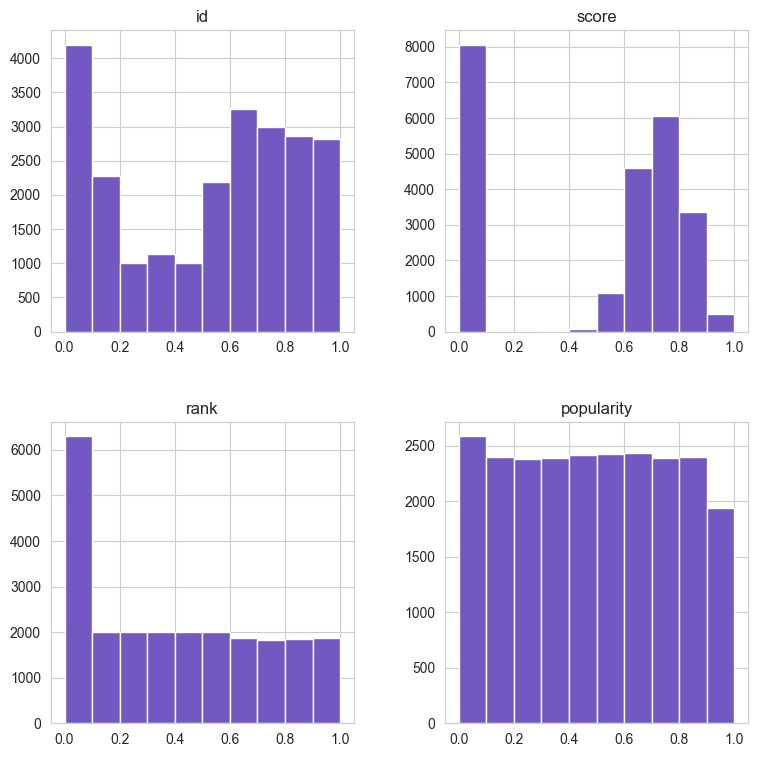

In [37]:
# ---- Applying Min-Max Scaler ----
#
# - variables without outliers
#
min_max_scaler(anime_exploratory_df[numerical_variables_without_outliers]).hist(bins=10, figsize=(9, 9), color='#7159c1');

Distributions Conclusions:

> **Score** - we can see that most common scores are between 6 to 8 and 0 to 1;

> **Rank** - this variable contains a Constant Distribution, telling that the rank values are well distributed between the animes. It's kind obvious, since two animes cannot be at the same rank position. The first bin is way taller than the others due to the animes without rank having their values set as -1, doing the first scaled bin containing more animes into it.

> **Popularity** - also contains a Constant Distribution. The first bin is higher taller than the others because all animes without informed popularity had their values set as -1, doing the first scaled bin looks bigger. The last bin is shorter than the others due to have less animes contained.

---

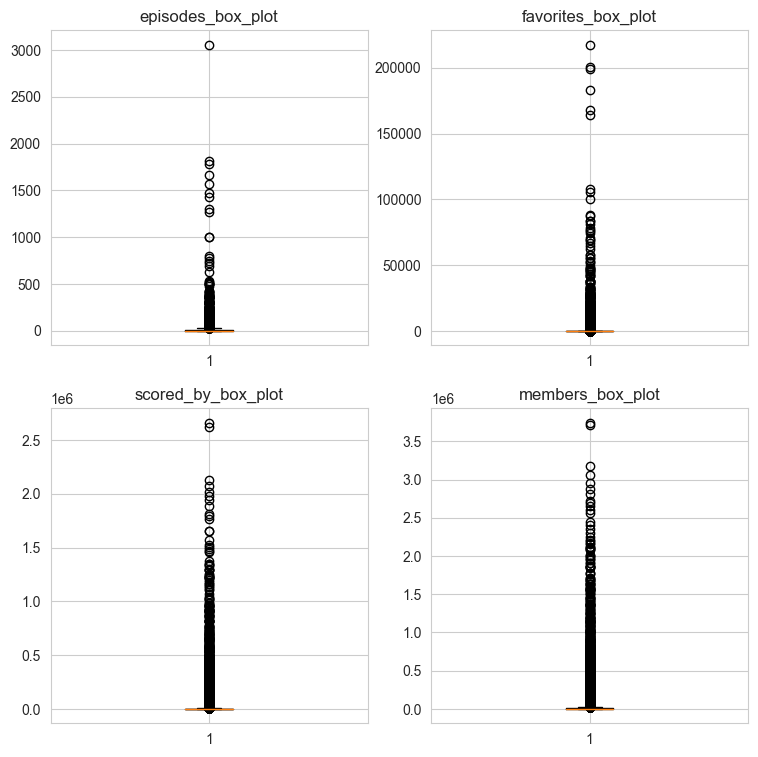

In [53]:
# ---- Box Plots ----
figure, axis = plt.subplots(2, 2, figsize=(9, 9))  # 2 rows, 2 columns

for row_index in range(0, 2):
    for column_index in range(0, 2):
        current_variable = numerical_variables_with_outliers[row_index * 2 + column_index]
        axis[row_index, column_index].set_title(f'{current_variable}_box_plot')
        axis[row_index, column_index].boxplot(anime_exploratory_df[current_variable])

plt.show()

Realize that all circles are outliers and the red line is, in reality, a box containing all of inthe inliers. With this, we can assume that all inliers are into a restricted small range, whereas the outliers are into a huge larger range.

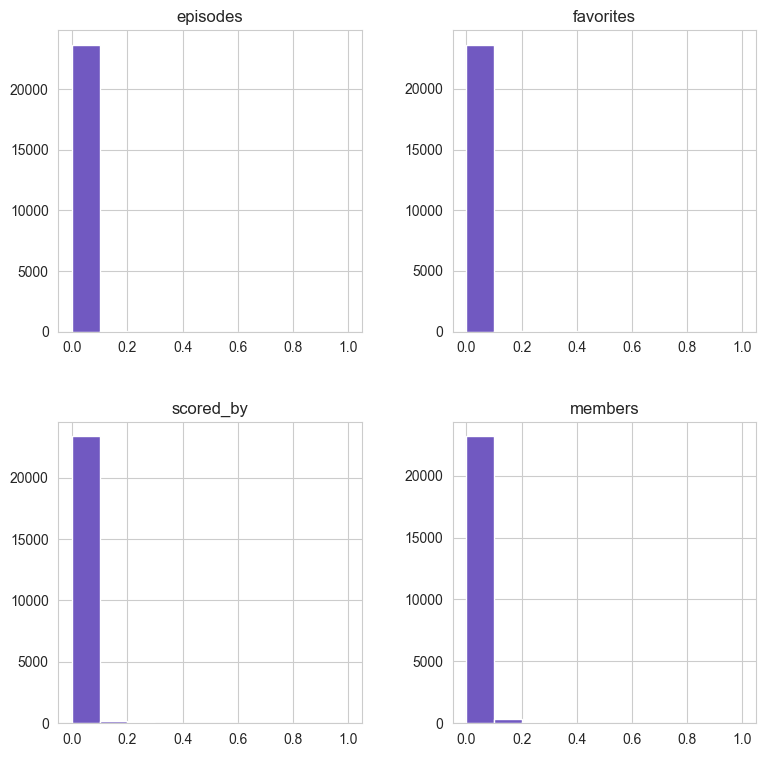

In [55]:
# ---- Applying Min-Max Scaler ----
#
# - see how the distributions are transformed when the variable contains a lot of outliers;
# - Spoiler: it looks like a single bar.
#
min_max_scaler(anime_exploratory_df[numerical_variables_with_outliers]).hist(bins=10, figsize=(9, 9), color='#7159c1');

Due to the outliers, the Min-Max Scaler does not work on the variables, resulting in a single bin in the distribution. Sometimes the distribution can contain more bins, but their are too small that are barely visible.

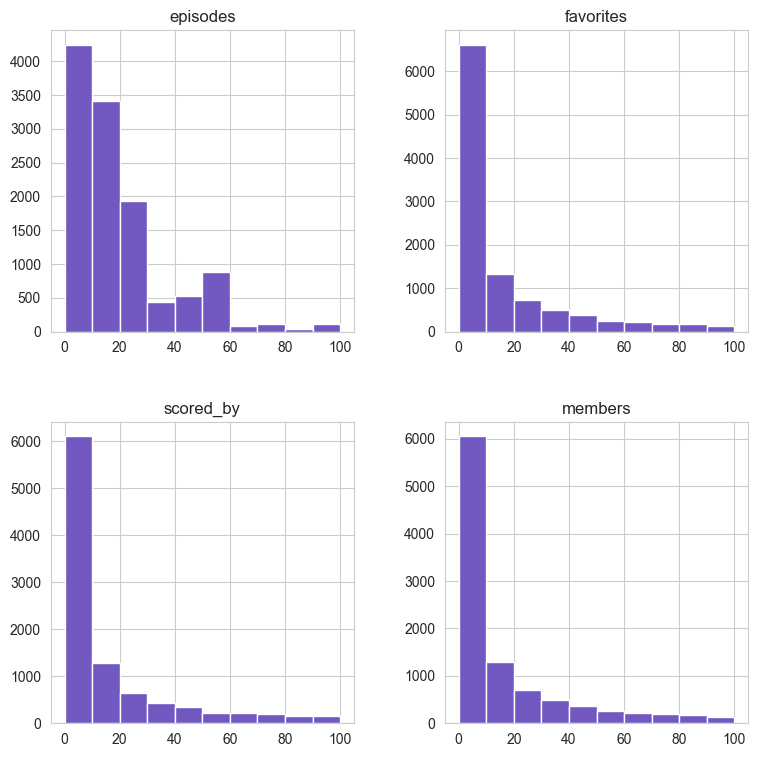

In [83]:
# ---- Applying Robust Scaler ----
#
# - now, see how the Robust Scaler works better on variables with outliers.
#
robust_scaler(anime_exploratory_df[numerical_variables_with_outliers]).hist(bins=10, figsize=(9, 9), range=(0, 100), color='#7159c1');

In [11]:
# ---- Correlations ----
anime_correlations = anime_exploratory_df[numerical_variables].corr()
anime_correlations

,id,score,episodes,rank,popularity,favorites,scored_by,members
id,1.000000,-0.519623,-0.005774,0.265549,0.522430,-0.051711,-0.077055,-0.085053
score,-0.519623,1.000000,-0.059805,-0.682911,-0.825803,0.120555,0.217729,0.249121
episodes,-0.005774,-0.059805,1.000000,0.100771,0.060595,0.046247,0.032720,0.033328
rank,0.265549,-0.682911,0.100771,1.000000,0.600773,-0.112733,-0.194457,-0.219747
popularity,0.522430,-0.825803,0.060595,0.600773,1.000000,-0.166473,-0.323112,-0.370172
favorites,-0.051711,0.120555,0.046247,-0.112733,-0.166473,1.000000,0.785385,0.773223
scored_by,-0.077055,0.217729,0.032720,-0.194457,-0.323112,0.785385,1.000000,0.989114
members,-0.085053,0.249121,0.033328,-0.219747,-0.370172,0.773223,0.989114,1.000000


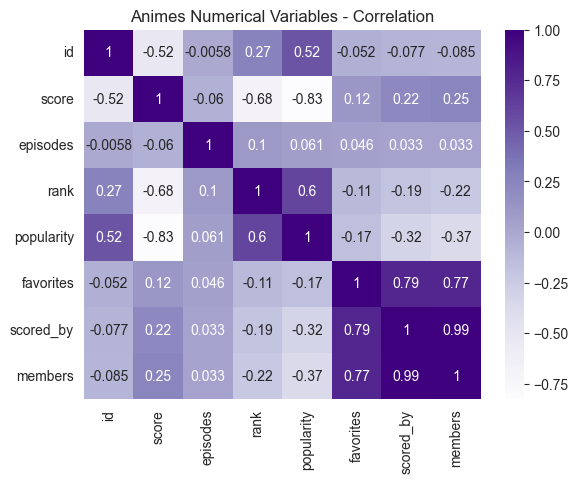

In [12]:
# ---- HeatMap ----
plt.title('Animes Numerical Variables - Correlation')

sns.heatmap(
    data=anime_correlations
    , cmap='Purples'
    , annot=True
)

plt.show()

---

**Genre Variables: Frequence Table, Bar Plots, Correlations, HeatMap Plot and Conclusions**

In [13]:
# ---- Frequence Table ----
genre_frequencies = pd.DataFrame()
for genre in genre_variables:
    temp_frequency = pd.DataFrame(anime_exploratory_df[genre].value_counts())
    genre_frequencies = pd.concat([genre_frequencies, temp_frequency], axis=1)
genre_frequencies

,genre_avant_garde,genre_award_winning,genre_mystery,genre_slice_of_life,genre_comedy,genre__,genre_romance,genre_horror,genre_ecchi,genre_supernatural,genre_boys_love,genre_fantasy,genre_suspense,genre_sports,genre_girls_love,genre_gourmet,genre_action,genre_sci_fi,genre_hentai,genre_drama,genre_adventure,genre_erotica
0,22950,23507,22921,22016,16792,19243,21766,23223,22965,22315,23587,18793,23519,23005,23642,23607,19211,20736,22273,21006,20044,23695
1,798,241,827,1732,6956,4505,1982,525,783,1433,161,4955,229,743,106,141,4537,3012,1475,2742,3704,53


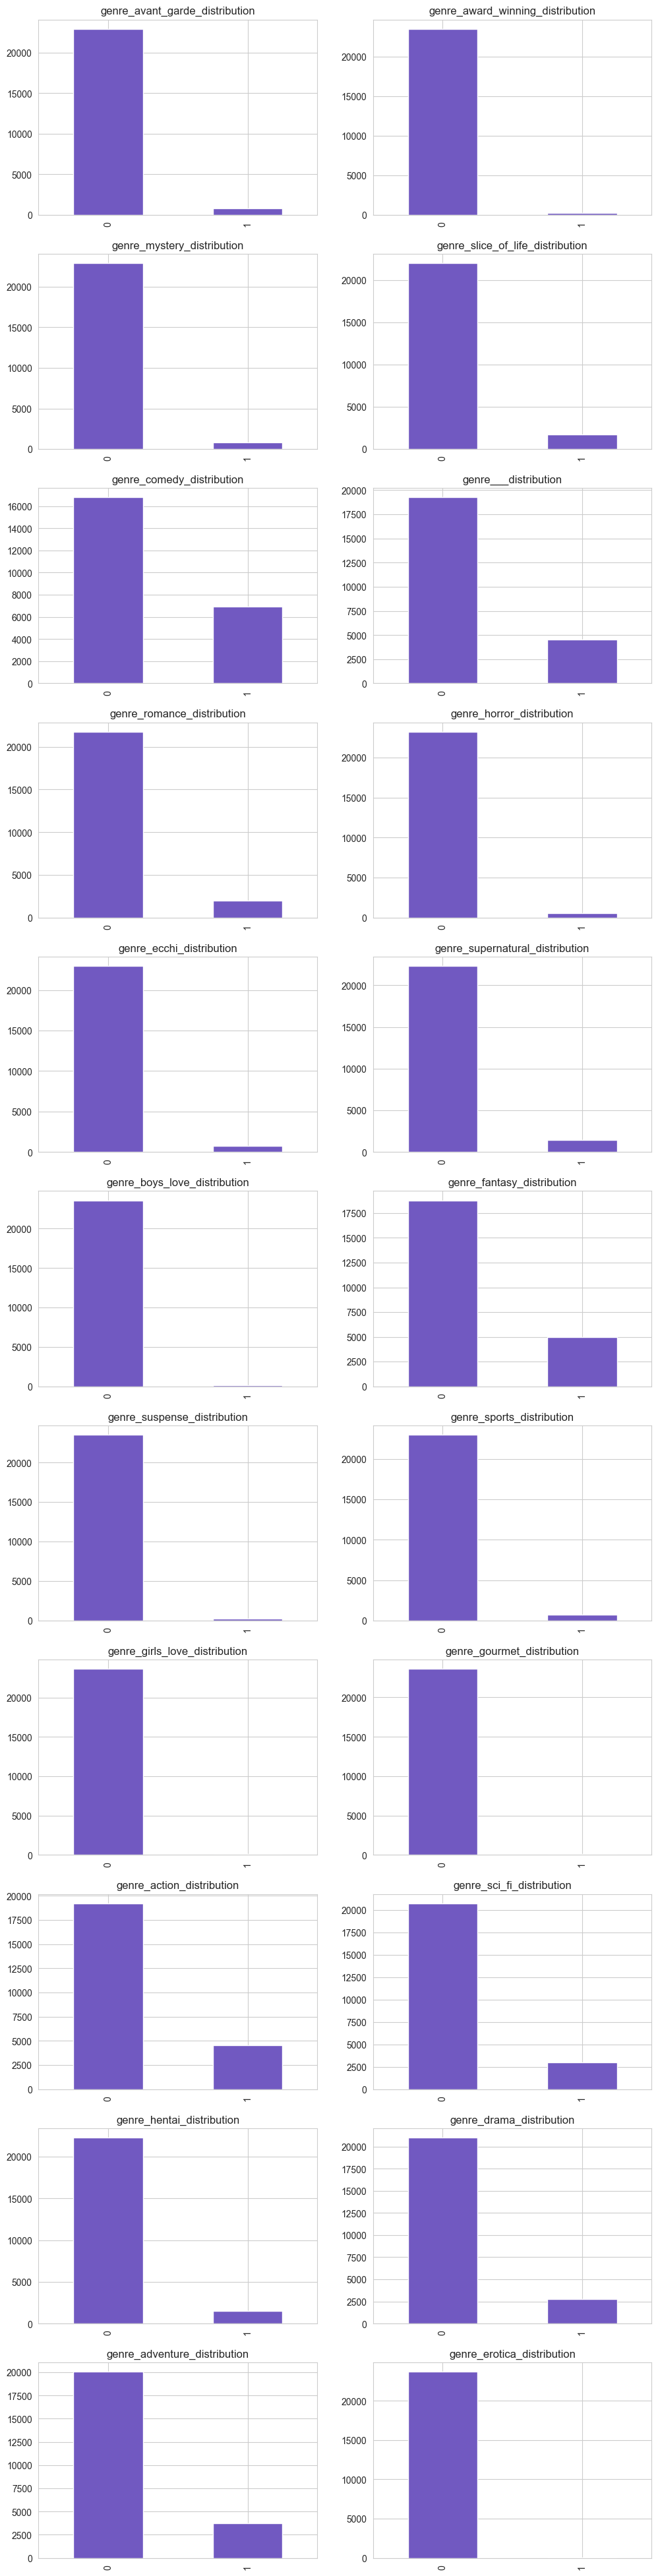

In [14]:
# ---- Bar Plots ----
figure, axis = plt.subplots(11, 2, figsize=(12, 50))  # 11 rows, 2 columns

for row_index in range(0, 11):
    for column_index in range(0, 2):
        current_genre = genre_variables[row_index * 2 + column_index]
        axis[row_index, column_index].set_title(f'{current_genre}_distribution')
        genre_frequencies[current_genre].plot(kind='bar', ax=axis[row_index, column_index], color='#7159c1')

plt.show()

In [16]:
# ---- Correlations ----
genre_correlations = anime_exploratory_df[genre_variables].corr()
genre_correlations

,genre_avant_garde,genre_award_winning,genre_mystery,genre_slice_of_life,genre_comedy,genre__,genre_romance,genre_horror,genre_ecchi,genre_supernatural,genre_boys_love,genre_fantasy,genre_suspense,genre_sports,genre_girls_love,genre_gourmet,genre_action,genre_sci_fi,genre_hentai,genre_drama,genre_adventure,genre_erotica
genre_avant_garde,1.000000,0.013760,-0.020125,-0.046011,-0.096397,-0.090224,-0.046131,0.045069,-0.027888,-0.024683,-0.012558,-0.079072,0.015076,-0.030827,-0.008981,-0.014411,-0.081109,-0.052812,-0.047018,-0.038123,-0.076295,0.020892
genre_award_winning,0.013760,1.000000,0.040350,0.007147,-0.012547,-0.048992,0.016537,-0.000937,-0.013991,0.020216,-0.008365,0.003842,0.041600,-0.008543,-0.000477,-0.007825,0.006367,0.038422,-0.026057,0.114604,0.002792,-0.004789
genre_mystery,-0.020125,0.040350,1.000000,-0.036494,0.004423,-0.091907,0.003304,0.115157,-0.018352,0.166001,0.001101,-0.022357,0.162233,-0.028859,-0.009273,-0.011690,0.081213,0.021472,-0.043171,0.054271,0.046219,-0.008983
genre_slice_of_life,-0.046011,0.007147,-0.036494,1.000000,0.074969,-0.135711,-0.031941,-0.041071,-0.028211,-0.018711,0.002482,-0.089024,-0.024362,-0.033663,-0.001775,0.049993,-0.126007,-0.069428,-0.070837,0.008117,-0.084866,-0.002970
genre_comedy,-0.096397,-0.012547,0.004423,0.074969,1.000000,-0.311415,0.095163,-0.042023,0.179111,0.014867,0.014480,-0.032873,-0.054988,-0.018406,0.020753,0.041792,-0.050586,-0.021476,-0.143777,-0.105723,0.012768,-0.001028
genre__,-0.090224,-0.048992,-0.091907,-0.135711,-0.311415,1.000000,-0.146007,-0.072750,-0.089343,-0.122613,-0.039975,-0.248448,-0.047744,-0.086955,-0.032398,-0.037394,-0.235137,-0.184406,-0.124514,-0.174813,-0.207996,-0.022883
genre_romance,-0.046131,0.016537,0.003304,-0.031941,0.095163,-0.146007,1.000000,-0.017413,0.161706,0.053326,0.077116,0.003544,-0.004849,-0.020124,0.041462,-0.007467,-0.011873,0.018584,-0.049268,0.200642,-0.014743,0.037351
genre_horror,0.045069,-0.000937,0.115157,-0.041071,-0.042023,-0.072750,-0.017413,1.000000,-0.011724,0.226498,0.005028,0.000324,0.140487,-0.025376,-0.001475,-0.011620,0.045677,0.015846,0.000465,0.027227,-0.014117,-0.001042
genre_ecchi,-0.027888,-0.013991,-0.018352,-0.028211,0.179111,-0.089343,0.161706,-0.011724,1.000000,0.035407,-0.015255,0.013712,-0.018220,-0.007447,0.047776,0.010286,0.048835,0.016079,-0.047518,-0.029817,-0.028030,-0.008733
genre_supernatural,-0.024683,0.020216,0.166001,-0.018711,0.014867,-0.122613,0.053326,0.226498,0.035407,1.000000,0.020009,-0.015229,0.074522,-0.042494,-0.003704,-0.012679,0.092318,-0.045567,-0.008063,0.044015,-0.009020,-0.004490


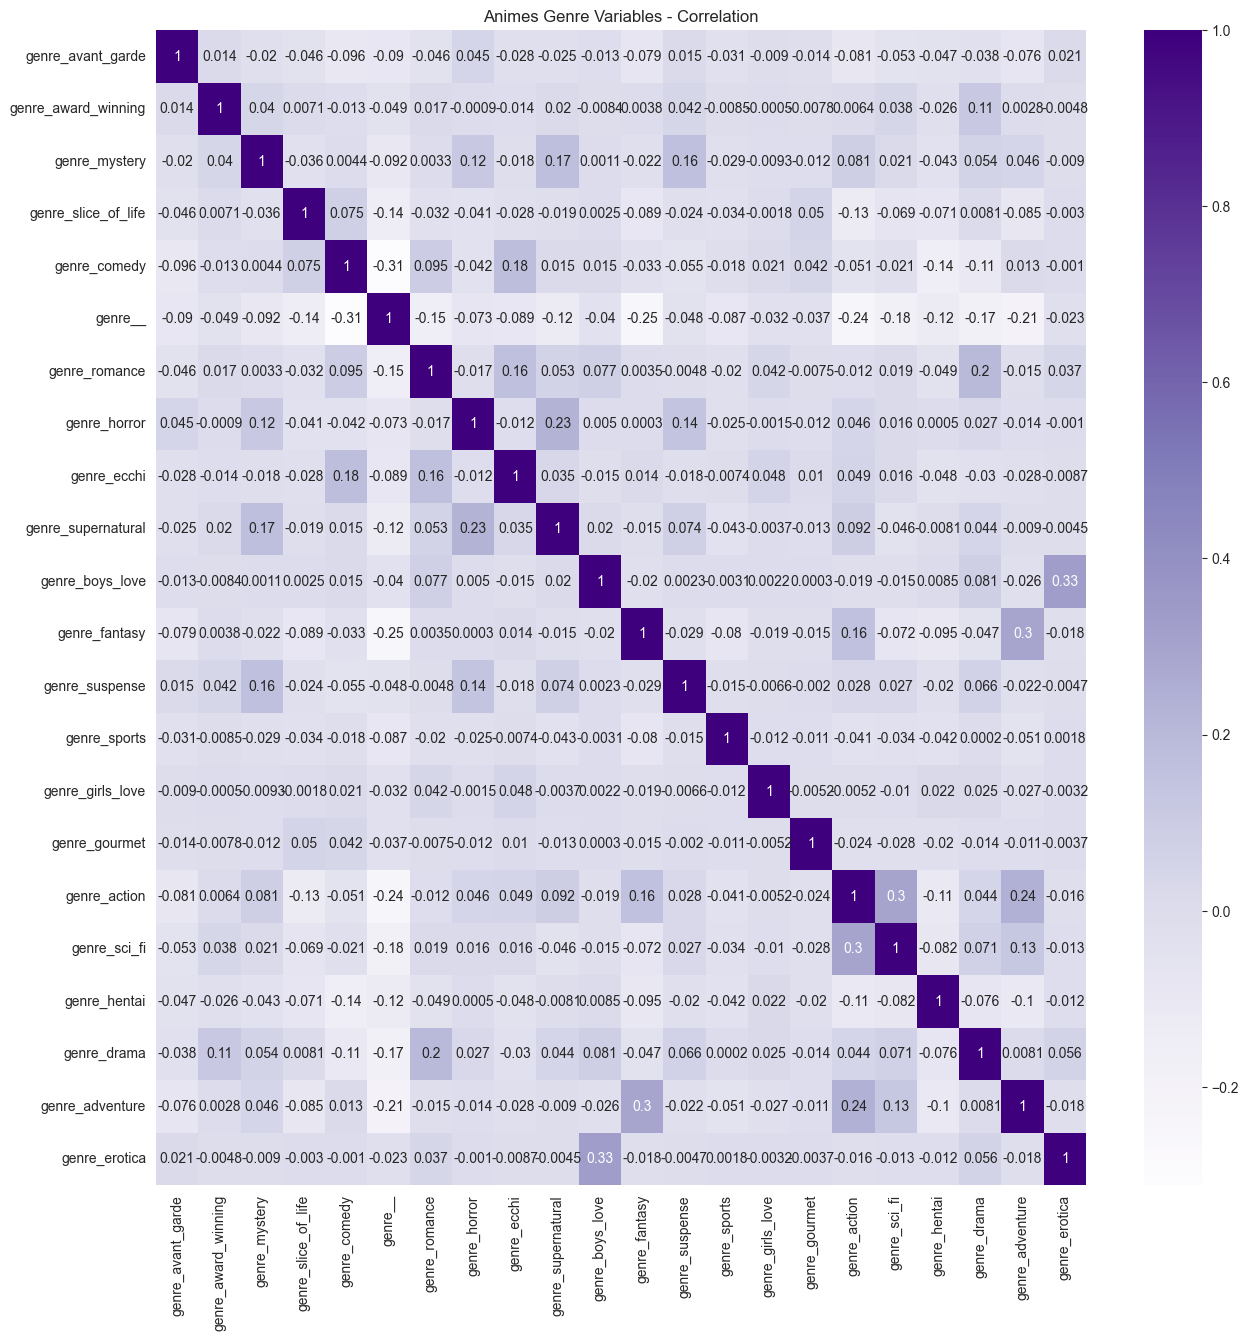

In [21]:
# ---- Heat Map ----
plt.figure(figsize=(15, 15))
plt.title('Animes Genre Variables - Correlation')

sns.heatmap(
    data=round(genre_correlations, 4)
    , cmap='Purples'
    , annot=True
)

plt.show()